# Section 05: Inferring and associating critical features

- Author: James Morton

---

## Preparation

Install the latest version of scikit-bio if it hasn't been (needed for every Google Colab instance).

In [1]:
from importlib.util import find_spec

In [2]:
if find_spec('skbio') is None:
    !pip install -q scikit-bio

In [3]:
import skbio
skbio.__version__

'0.7.2'

Import libraries.

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from skbio.table import Table
from skbio.stats.composition import clr, ilr, centralize, multi_replace, dirmult_ttest, ancom

Download the EMP500 dataset and unzip it. (If you have done it already, skip the following code.)

In [7]:
!wget -q -O emp500.tar.gz "https://www.dropbox.com/scl/fi/7sepykr3vhss60647osc8/emp500.tar.gz?rlkey=6q5ac48noeax5n2htaqslvo8g&dl=0"
!tar zxf emp500.tar.gz

In [8]:
HOME = 'emp500'

Check if the directory exists by listing its content.

In [9]:
!ls $HOME

README.md  amplicon  assembly  masspec	sample.tsv  shotgun


Read in the data.

In [10]:
table = Table.read(f'{HOME}/amplicon/subset/16s.biom')
metadata = pd.read_table(f'{HOME}/sample.tsv', index_col=0)

In [11]:
# subset the table down
subset = table.filter(lambda v, i, m: np.sum(v > 0) > 50, inplace=False, axis='observation')
subset = subset.filter(lambda v, i, m: np.sum(v > 0) > 10, inplace=False, axis='sample')
abundance_data = subset.to_dataframe(dense=True).T
md = metadata.loc[abundance_data.index]

# Differential abundance analysis

Differential abundance a commonly used technique to identify biomarkers that have changed in abundance across different conditions. It is a must have in the computational biologists tool box.  However, sometimes interpreting differential abundance results can be tricky, particularly if there are large changes. For instance, if a large microbial difference is detected between different environments, the next step is to identify microbes that explain the differences between these environments.  However, this problem can be tricky to answer due to the relative nature of the data that we measured.


The main issue behind differential abundance is compositionality, the mathematical nature of relative measurements.
Consider the example below

![composition](img/composition.png)

In the left environment we don't observe the entire environment, but we can count the number of blue and orange microbes.
If there is a major perturbation, and we again count the microbes, there are multiple possibilities that could have explained the difference of proportions between the two environments. One possibility is that the number of blue microbes decreased.  Another possibility is that both the number of blue and orange microbes increased.  The reason behind this confusion is because we are missing information about the total abundance.  More concretely, if we have environment *A = (a<sub>1</sub>, ... a<sub>D</sub>)* with proportions from *D* taxa and the same environment after perturbation *B = (b<sub>1</sub>, ... b<sub>D</sub>)*, then the following holds.

![](img/rank-equations1.png)

From sequencing we can measure the proportions _p<sub>A</sub>_ and _p<sub>B</sub>_, but in the majority of experiments, the total abundances _N<sub>A</sub>_ and _N<sub>B</sub>_ are inaccessible.  Due to this, the ratio _N<sub>A</sub>_ / _N<sub>B</sub>_ confounds our inference to determine if a microbe has changed or not.

In essence, it is not possible to infer absolute changes from relative data.

But fear not. While we often cannot infer the absolute change, there are a couple of workarounds.  First, we can compute something that looks like a concentration - by picking a reference microbe, we can look at their ratio, effectively negating the need to measure total biomass.

![](img/rank-equations2.png)


As a result, we can conduct a statistical test to determine if the log ratio of pairs of microbes have been altered across conditions. One of the outcomes of this procedure is, one would have to determine what a reference microbe needs to be.

Another workaround is to infer the relative changes (which we call the differential).  The ordering of the log fold change is consistent between absolute and relative abundances.

![](img/rank-equations3.png)

Here, the total biomass does not influence the ordering of the log fold change calculation. As a result, the ranking of the log fold change between the proportions is equal to the ranking of the log fold change between the absolute abundances. This is a huge win for differential abundance methodologies, since many methods can already infer the differential.  The major outstanding issue is how to determine which microbes to focus on.  Since the total biomass fluctuation will confound the absolute log fold change estimates, it won't be possible to build a statistical test to determine if a microbe's abundance has changed or not.

More information these concepts can be found in our paper [here](https://www.nature.com/articles/s41467-019-10656-5)

In this tutorial, we will give a high level overview of how to leverage techniques from compositional data analysis
to explore your data, perform differential abundance tests, and evaluate your findings.

## Compositional data transforms

One of the most commonly used transforms in compositional data analysis is the center log-ratio (CLR) transform.
The transform itself is given as follows

$$
clr(x) = \bigg[\log \frac{x_1}{g(x)} ... \log \frac{x_D}{g(x)}\bigg]
$$

where $g(x)$ is the geometric mean of the abundances $x$ within a sample. In essense, this is a log transform, where the "reference" is the geometric mean. When performing statistical tests, the underlying assumption here is that the geometric mean is constant across samples.  While this may not always be true, the CLR transform none-the-less is a useful transform, especially when initially performing data exploration.

One strict requirement of the CLR transform is that the input data needs to be non-zero, otherwise there is an issue of computing $\log(0)$ (which isn't defined). The most common approach around this issue is to perform some type of imputation. Here, we will use the multiplicative replacement (aka the `multi_replace` function) to perform imputation. One benefit of this approach is that the ratios of the observed abundances will be preserved (which isn't the case if you add (`+1`) to all of the entries).

First, let's apply the multiplicative replacement function to our data, then we will perform a CLR transform and visualize the resulting table.

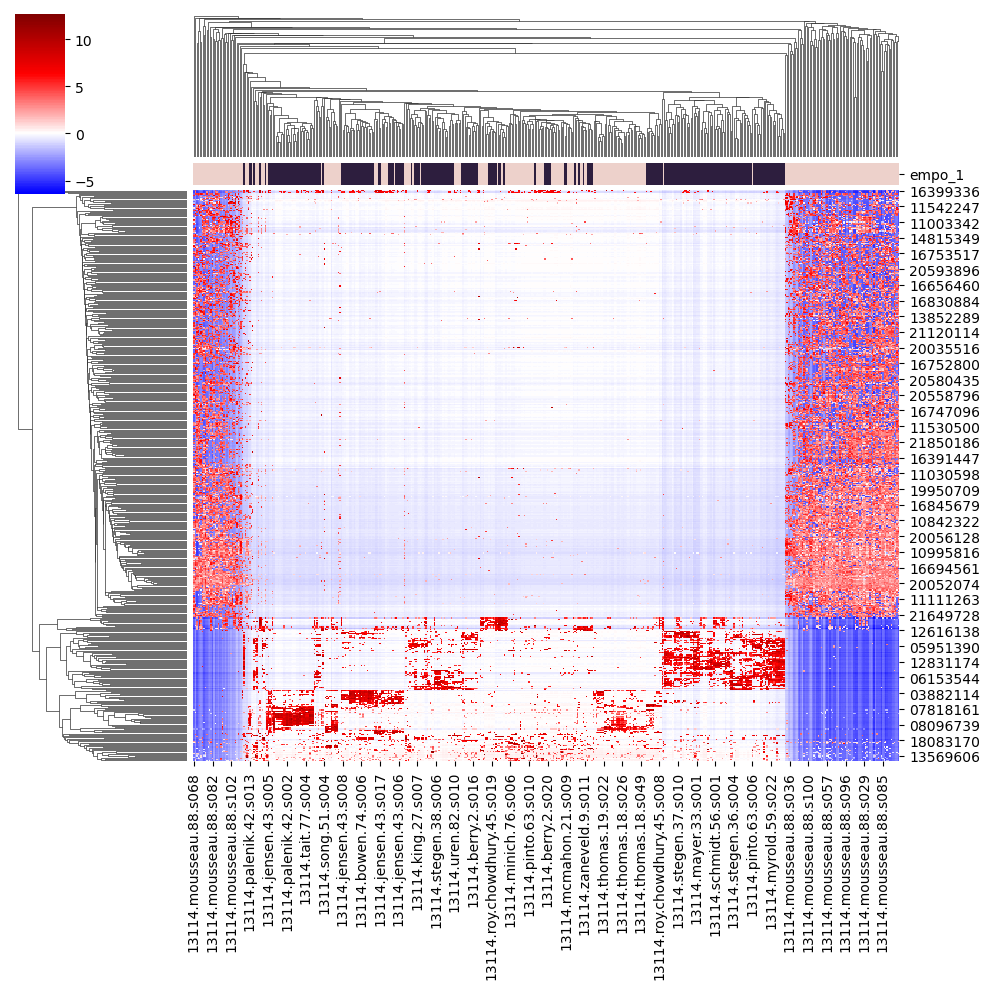

In [12]:
# perform multiplicative replacement. 
pos_abundance_data = abundance_data.apply(multi_replace)
# Apply the CLR transform. Compositional transforms applied to dataframes 
# work best using row-wise operations, hence the transpose
clr_abundance_data = pos_abundance_data.T.apply(clr)
# double center the data
centered_data = clr_abundance_data - clr_abundance_data.mean(1).values.reshape(-1, 1)
# get seaborn color palette
pal = sns.cubehelix_palette(md['empo_1'].unique().size)
# assign labels to colors
lut = dict(zip(map(str, md['empo_1'].unique()), pal))
# visualize the abundances as a heatmap, centered around 0
sns.clustermap(centered_data, cmap='seismic', center=0, col_colors=md['empo_1'].map(lut));

We can see that there is clear clustering in our abundance table after applying the CLR transform, and this clustering
pattern is being strongly driven by the `empo_1` category that differentiates between freeliving (i.e. soil and ocean water samples) vs host-associated (i.e. human fecal samples)

We will first perform a simple differential abundance test under the function `dirmult_ttest`. Underneath the hood, this performs Dirichilet-Multinomial bootstrapping of the underlying samples, enabling the calculation of uncertainty. A T-test is applied on each Dirichlet-Multinomial bootstrap after applying the CLR transform.  This method was leveraged the ideas from ALDEx2. See the [ALDEx2 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4030730/) for a more detailed explanation.

To run the T-test, only the raw abundance table, the metadata specifying the sample categories (i.e. Free-living and Host-associated), in addition to assigning which class corresponds to treatment or reference is needed. Specifying the `treatment` and `reference` is a requirement here in order to more easily interpret the resulting statistics. With these labels defined, it becomes clear that biomarkers with a positive log-fold change will correspond to `Free-living`, while biomarkers with a negative log-fold change will correspond to `Host-associated`. For the sake of this tutorial, we will only specify `draw=3` in order to reduce the runtime.

In [13]:
res = dirmult_ttest(abundance_data, md['empo_1'], 
                    treatment='Free-living', reference='Host-associated', 
                    draws=3)

In [14]:
res

,T-statistic,Log2(FC),CI(2.5),CI(97.5),pvalue,qvalue,Signif
19794598,6.083841,2.154261,1.316213,3.095138,5.552236e-09,2.276417e-06,True
21850186,-1.159604,-0.326488,-1.032621,0.524494,3.349088e-01,1.000000e+00,False
21213937,-1.398440,-0.463247,-1.159526,0.256380,1.656256e-01,1.000000e+00,False
19806606,0.984436,0.313286,-0.441507,1.105043,3.728013e-01,1.000000e+00,False
07597626,9.442019,3.294506,2.377784,4.193577,7.569037e-17,3.769380e-14,True
...,...,...,...,...,...,...,...
20560436,-0.577504,-0.178730,-0.930048,0.467111,5.784188e-01,1.000000e+00,False
11968053,5.167054,2.073482,0.956932,3.085232,7.007759e-06,2.557832e-03,True
20053715,-10.028574,-3.331972,-4.091603,-2.433194,3.599441e-18,1.814118e-15,True
20566837,1.099619,0.319329,-0.413901,1.000803,3.233312e-01,1.000000e+00,False


We can inspect the results to determine what is being calculated. The columns that we will focus on is 
`Log2(FC)`, `CI(2.5)` and `CI(97.5)` and `Signif`. `Log2(FC)` represents the mean log-fold change of a given biomarker between the free-living and host-associated environments. `CI(2.5)` and `CI(97.5)` provide 2.5% and 97.5% credible intervals, capturing the uncertainty of measurement error. `Signif` determines if the log-fold-change is significantly different, **assuming** that the mean abundance has not changed (this assumption will need be carefully considered).

We can visualize the resulting log-fold changes and their credible intervals as follows, where the x axis is the rank of the microbe wrt its log-fold change, and the y axis is the log fold-change. Microbes that are deemed to be statistically significant are highlighted in orange.

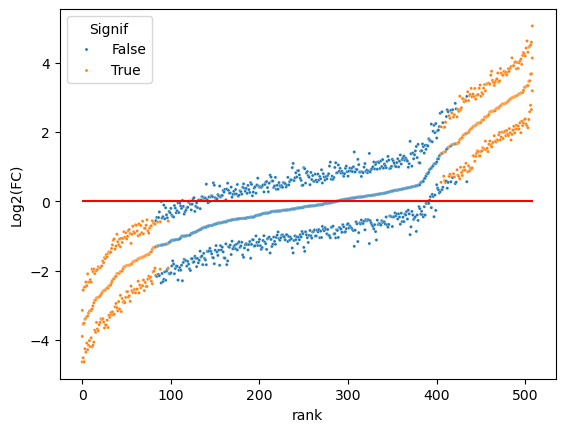

In [15]:
# extract rank information by sorting by log-fold-change
ttest_res = (res
             .sort_values('Log2(FC)')
             .reset_index(names='featureid')
             .reset_index(names='rank'))

sns.scatterplot(data=ttest_res, x='rank', y='Log2(FC)', s=5, color='b', hue='Signif')
sns.scatterplot(data=ttest_res, x='rank', y='CI(2.5)', s=5, color='b', hue='Signif', legend=False)
sns.scatterplot(data=ttest_res, x='rank', y='CI(97.5)', s=5, color='b', hue='Signif', legend=False)
plt.hlines(0, xmin=0, xmax=len(res), color='r');

An alternative framework is ANCOM, which makes a slightly different assumption. Rather than assuming that mean
abundance as not changed across samples, it assumes that the majority of biomarkers have not significantly changed in abundance.
We can run ancom using the following.

In [16]:
ancom_res, perc = ancom(pos_abundance_data, md['empo_1'])

And we can generate a volcano plot of the individual biomarkers, where the x axis is the mean CLR abundance and the y axis is the ANCOM 
W-statistic. Microbes that are deemed to be statistically significant are highlighted in orange.

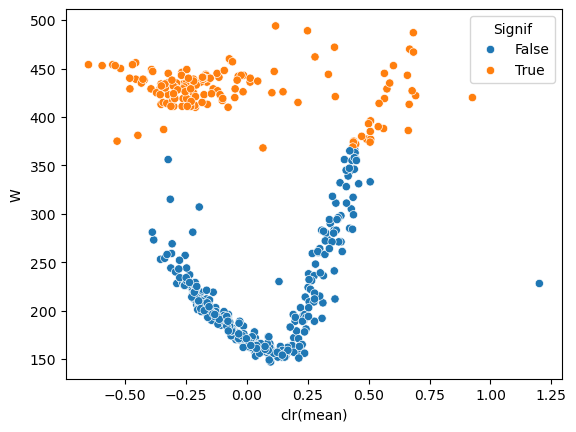

In [17]:
m = clr_abundance_data.mean(axis=1)
ancom_res['clr(mean)'] = m

sns.scatterplot(data=ancom_res, x='clr(mean)', y='W', hue='Signif');

One question that one may ask is how relevant are these assumptions? It really depends on the use-case.
We can investigate the differences between ANCOM and the Dirichlet Multinomial t-test.

Aside from the different assumptions, there are two major difference between ANCOM and the Dirichlet Multinomial t-test.
First ANCOM computes a positive statistic that doesn't differentiate between "increased" or "decreased" biomarkers. To make it comparable to the t-test, we can consider the squared T-statistic.

Second, ANCOM doesn't compute credible intervals, so it can be difficult to evaluate how robust the W-statistic can be.
This is especially pronounced when considering low-abundance biomarkers. The presence of many zeros can skew statistical results. While this can be somewhat alleviated using non-parameteric tests within ANCOM, handling zeros can be a source of measurement uncertainty.

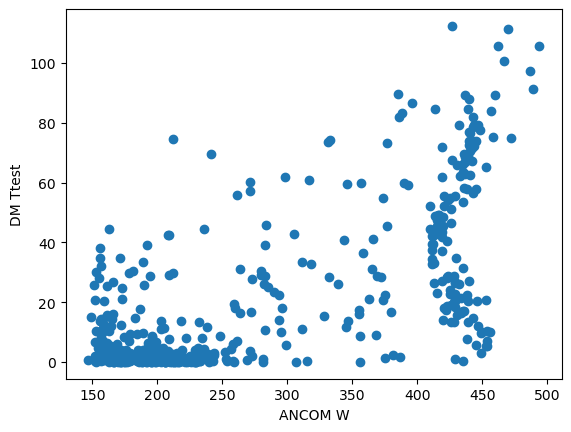

In [18]:
ancom_res = ancom_res.loc[ttest_res['featureid']]

plt.scatter(ancom_res['W'], ttest_res['T-statistic']**2)
plt.xlabel('ANCOM W')
plt.ylabel('DM Ttest');

## Constructing balances

One challenge with dealing with differential abundance analysis is that it isn't always straightforward to sanity check the results.
Another way to perform validation is to construct so-called *balances*. The idea here is that you can construct a single log-ratio 
that is the ratio of biomarkers that "increased" and biomarkers that "decreased" through the following formula
$$
b = \log\bigg( \frac{g(x_{increased})}{g(x_{decreased})} \bigg)
$$

By constructing a single log-ratio, one can construct a "classifier" from the differential abundance results. 
The best part of this is that it is relatively simple to construct one of these balances. It can be done as follows

In [19]:
# select "increased" biomarkers by determining if the 2.5% confidence interval (aka lower bound) is greater than 0.
inc = ttest_res.query("`CI(2.5)` > 0")
# select "decreased" biomarkers by determining if the 97.5% confidence interval (aka upper bound) is greater than 0.
dec = ttest_res.query("`CI(97.5)` < 0")
# compute the numerator of the log-ratio
num = np.log(pos_abundance_data[inc.featureid]).mean(1)
# compute the denominator of the log-ratio
denom = np.log(pos_abundance_data[dec.featureid]).mean(1)
# compute the log-ratio by dividing (aka subtracting logs)
balance = num - denom

As we can see, the constructed balance can strongly differentiate between the free-living and host-associated samples.

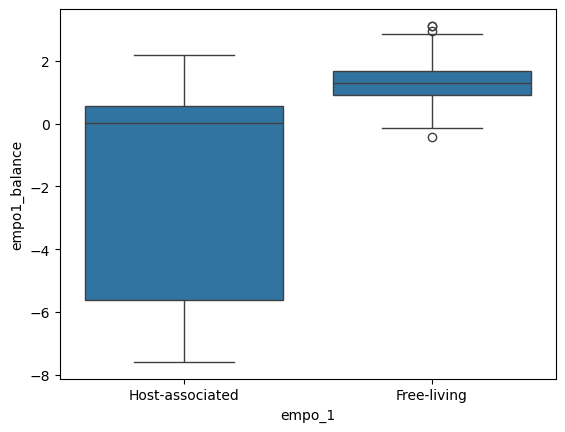

In [20]:
md['empo1_balance'] = balance

sns.boxplot(data=md, y='empo1_balance', x='empo_1');

One important takeaway here is that differentiable abundance analyses can be directly used to inform classification analysis.
This also has the important implication that best practices for classifaction analysis also apply to differential abundance analysis.
Differential abundance analysis *can* be prone to overfitting for instance, so having hold-out datasets can be useful for evaluating
the generalizability of a given differential abundance analysis. We will further discuss best practices in the classification section.